# HRTF Identification

The task of this notebook is to compute an HRTF from a sweep recorded at the blocked ear channel entrances.

In [1]:
import pyfar as pf
import sofar as sf
import matplotlib.pyplot as plt
import os
%matplotlib inline

print(f'last tested with pyfar v{pf.__version__} and sofar v{sf.__version__}')

last tested with pyfar v0.7.0 and sofar v1.2.0


### 1. Load the data

Start with loading the example data for this task. It is taken from the FABIAN
HRTF Database.

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

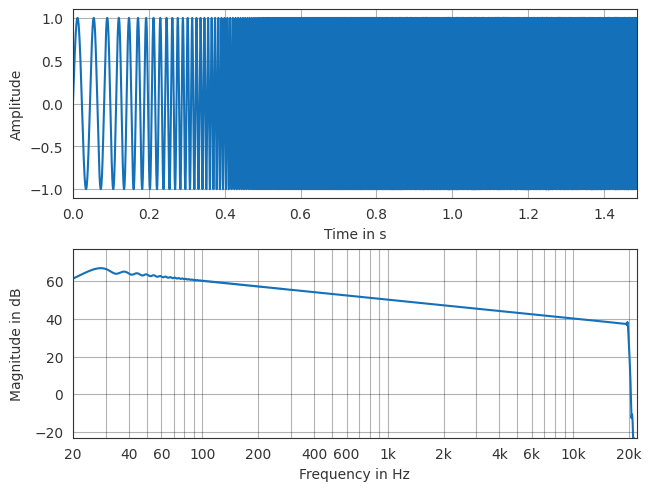

In [2]:
data_dir = os.path.join('..', '..', 'Resources')
data = pf.io.read(os.path.join(data_dir, 'hrir_measurement.far'))

# this is a reference HRIR, directly from the FABIAN database. In this case
# the low frequency extrapolation was done with numerically simulated data
hrir_reference = data['hrir']

# this is a sweep recorded at the ears of the same dummy head
# (It is actually a simulation of that, which was generated by convolving a
# sweep with the reference HRTF, adding some noise, reflections, and the
# frequency response of a loudspeaker)
hrir_recorded = data['hrir_recorded']

# this is the sweep signal itself
reference = data['reference']

# get familiar with the data and generate time frequency plots
pf.plot.time_freq(reference)


### 2. Deconvolution

The first step is to obtain the raw HRTF by means of deconvolution, i.e.,

$H = \frac{Y}{X}$

Where $H$ is the HRTF (complex spectrum), $Y$ the signal recorded at the ears, and $X$ the measurement signal.
Note that regularized inversion is often used to compute the inverse $1/X$.

**a) Invert the sweep and plot the result**

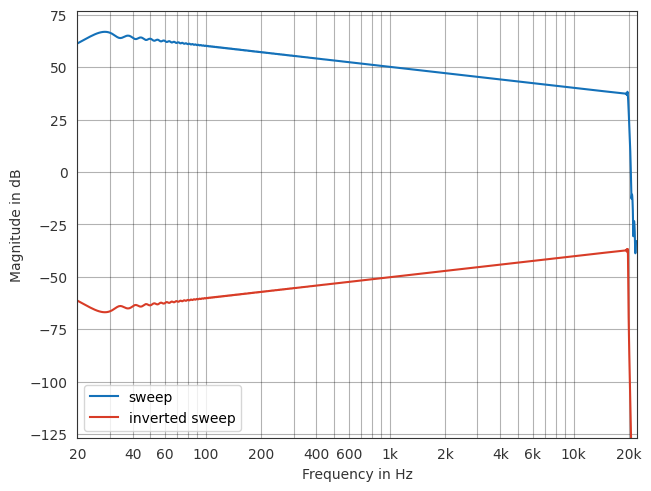

In [3]:
# sweep inversion
reference_inverted = pf.dsp.regularized_spectrum_inversion(
    reference, frequency_range=(20, 19.75e3))

ax = pf.plot.freq(reference, label='sweep')
ax = pf.plot.freq(reference_inverted, label='inverted sweep')
ax.legend(loc='lower left')

**b) Deconvolve and plot the HRTF**

(-40.0, 20.0)

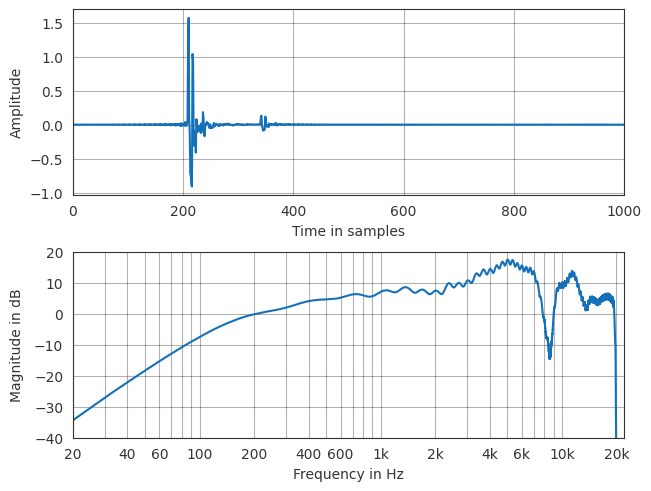

In [4]:
hrir_deconvolved = hrir_recorded * reference_inverted

ax = pf.plot.time_freq(hrir_deconvolved, unit='samples')
ax[0].set_xlim(0, 1e3)
ax[1].set_ylim(-40, 20)

### 3. Windowing

Acoustic measurements usually contain reflections, even if they were done in an anechoic chamber. In this case reflections may come from the measurement equipment itself (other loudspeakers, supporting construction, etc.) or from the room (door, floor, etc.).

Reflections show up in the impulse response as peaks that follow the direct sound. In the spectrum they cause a ripple (comb-filter) effect.

Window (shorten) the HRIR and find a find window that is as long as possible to maintain the frequency response at low frequencies, and  short enough to discard the reflection(s). Plot your result to see the effect of the time window.

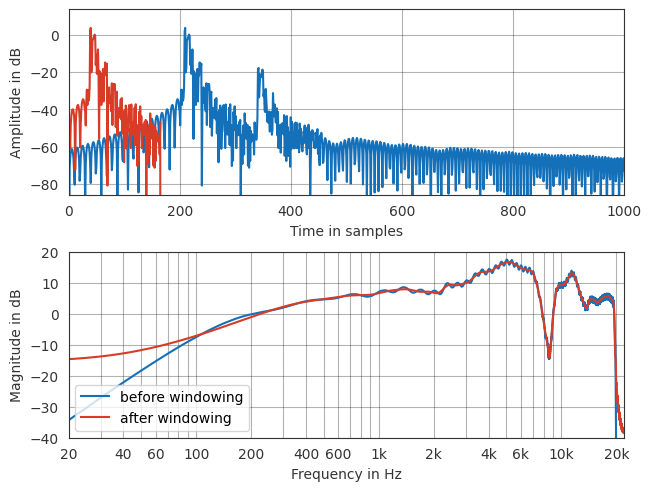

In [5]:
# apply time window
hrir_windowed = pf.dsp.time_window(
    hrir_deconvolved, (170, 335), 'boxcar', unit='samples', crop='window')

# pad to original length for plotting and further processing
hrir_windowed = pf.dsp.pad_zeros(
    hrir_windowed, hrir_deconvolved.n_samples-hrir_windowed.n_samples)

ax = pf.plot.time_freq(
    hrir_deconvolved, unit='samples', dB_time=True, label='before windowing')
pf.plot.time_freq(
    hrir_windowed, unit='samples', dB_time=True, label='after windowing')
ax[0].set_xlim(0, 1e3)
ax[1].set_ylim(-40, 20)
ax[1].legend(loc='lower left')

### 4. Low frequency extrapolation

HRTFs can usually not be measured at low frequencies. Hence, a low frequency extrapolation is required. Because the human body is small compared to the wave-length at low frequencies, it is reasonable to assume that the HRTFs is approx. 0 dB at low frequencies, which makes it rather easy to extrapolate.

**a) High pass the HRTF using a Linkwitz-Riley cross-over network, low-pass an impulse using the same cross-over, and plot the result.**

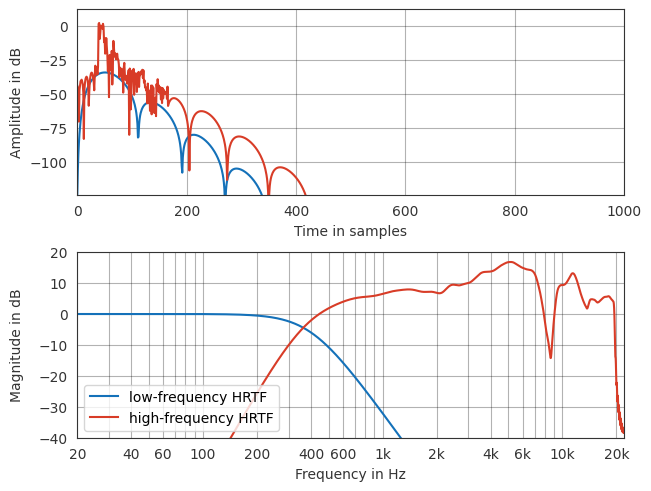

In [6]:
# low-pass HRIR using cross-over filter
hrir_low = pf.dsp.filter.crossover(
    pf.signals.impulse(hrir_windowed.n_samples), 4, 400)[0]

# high-pass HRIR using same cross over
hrir_high = pf.dsp.filter.crossover(hrir_windowed, 4, 400)[1]

ax = pf.plot.time_freq(
    hrir_low, unit='samples', dB_time=True, label='low-frequency HRTF')
pf.plot.time_freq(
    hrir_high, unit='samples', dB_time=True, label='high-frequency HRTF')
ax[0].set_xlim(0, 1e3)
ax[1].set_ylim(-40, 20)
ax[1].legend(loc='lower left')

If everything went well, the previous plot showed you that the low and high-pass output from the cross-over can well be combined. The problem is that they might not be aligned in time. Without alignment, there will not be a smooth transition between the two parts.

**b) Align the two parts, add them, and plot the results**

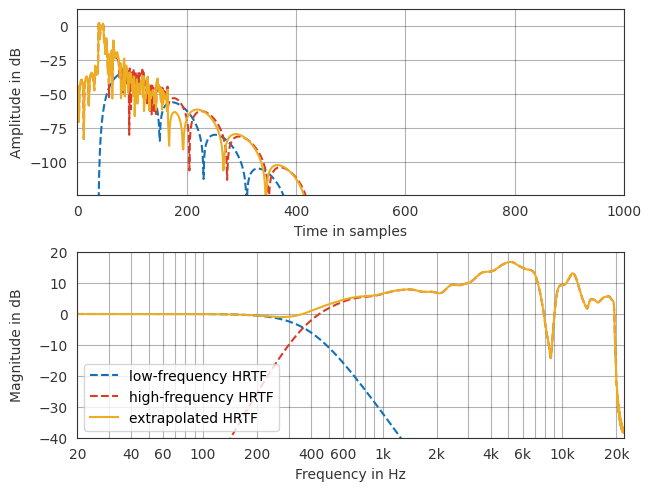

In [7]:
# delay impulse according to the delay of the HRIR
hrir_low_delayed = pf.dsp.fractional_time_shift(
    hrir_low, pf.dsp.find_impulse_response_delay(hrir_windowed))

# add impulse and HRIR
hrir_extrapolated = hrir_low_delayed + hrir_high

ax = pf.plot.time_freq(
    hrir_low_delayed, unit='samples', dB_time=True,
    label='low-frequency HRTF', ls='--')
pf.plot.time_freq(
    hrir_high, unit='samples', dB_time=True,
    label='high-frequency HRTF', ls='--')
pf.plot.time_freq(
    hrir_extrapolated, unit='samples', dB_time=True,
    label='extrapolated HRTF')
ax[0].set_xlim(0, 1e3)
ax[1].set_ylim(-40, 20)
ax[1].legend(loc='lower left')


### 5. Window to final length

HRIRs should be as short as possible, usually they can be shortened to 128 or 256 samples after proper low-frequency extrapolation. Shorten the HRIR and compare it to the full-length version.

(-25.0, 25.0)

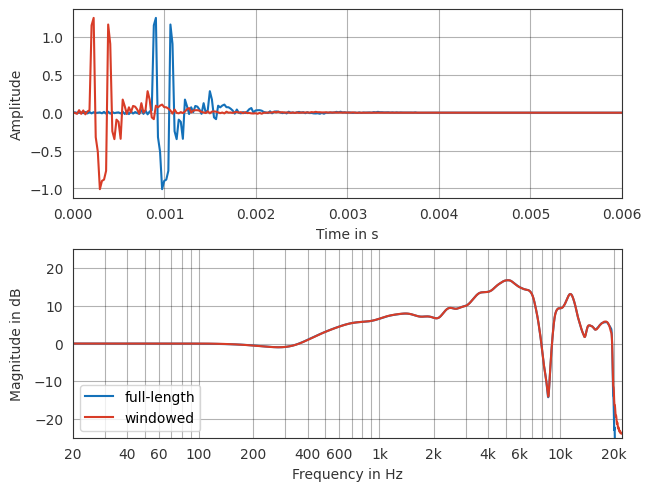

In [8]:
# window to final length
n_start = 30
n_samples = 256
hrir_final = pf.dsp.time_window(
    hrir_extrapolated, (n_start, n_start + n_samples), 'boxcar',
    crop='window')

# compare against full length (pad zeros to increase FFT resolution)
ax = pf.plot.time_freq(hrir_extrapolated, label='full-length')
pf.plot.time_freq(
    pf.dsp.pad_zeros(hrir_final, hrir_extrapolated.n_samples - n_samples),
    label='windowed')
ax[1].legend(loc='lower left')
ax[0].set_xlim(0, 6e-3)
ax[1].set_ylim(-25, 25)


### Compare to reference

In this case, we can compare the final result to the reference HRTF by plotting

(-25.0, 25.0)

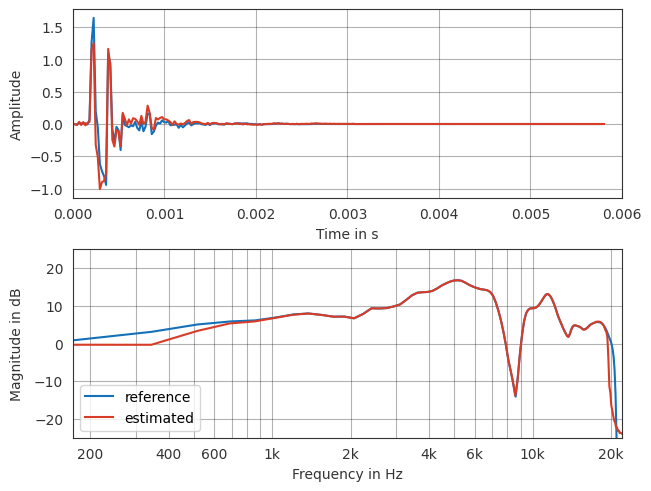

In [9]:
ax = pf.plot.time_freq(hrir_reference, label='reference')
pf.plot.time_freq(hrir_final, label='estimated')
ax[1].legend(loc='lower left')
ax[0].set_xlim(0, 6e-3)
ax[1].set_ylim(-25, 25)
